In [1]:
import cv2
import os
import numpy as np
from random import shuffle
from tqdm import tqdm
import glob
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from fastai import *
from fastai.vision import *
from fastai.metrics import error_rate
import pathlib
import PIL
from tensorflow import keras
from tensorflow.keras import layers
import seaborn as sns

In [2]:
data_dir = '/kaggle/input/mangoleafbd/MangoLeafBD Dataset'
data_dir = pathlib.Path(data_dir)

In [3]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

4000


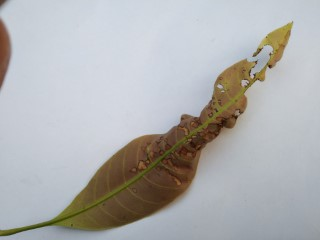

In [4]:
Anthracnose = list(data_dir.glob('Anthracnose/*'))
PIL.Image.open(str(Anthracnose[1]))

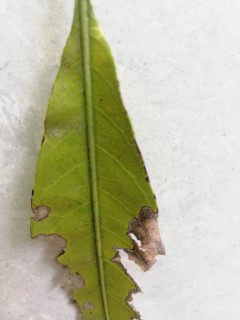

In [5]:
bc = list(data_dir.glob('Bacterial Canker/*'))
PIL.Image.open(str(bc[1]))

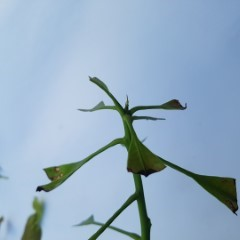

In [6]:
cw = list(data_dir.glob('Cutting Weevil/*'))
PIL.Image.open(str(cw[1]))

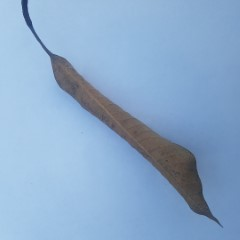

In [7]:
db = list(data_dir.glob('Die Back/*'))
PIL.Image.open(str(db[0]))

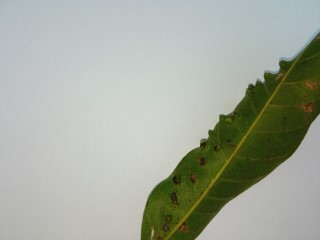

In [8]:
gm = list(data_dir.glob('Gall Midge/*'))
PIL.Image.open(str(gm[0]))

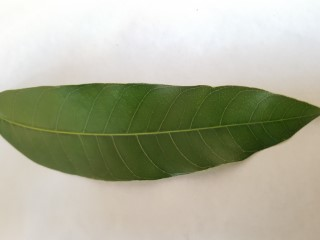

In [9]:
h = list(data_dir.glob('Healthy/*'))
PIL.Image.open(str(h[0]))

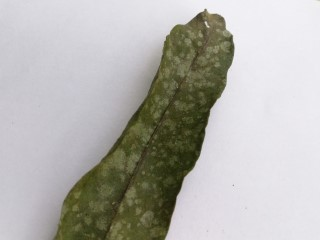

In [10]:
pm = list(data_dir.glob('Powdery Mildew/*'))
PIL.Image.open(str(pm[0]))

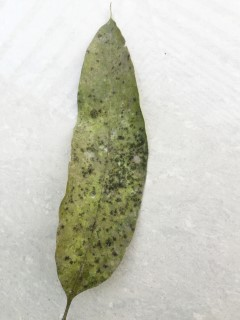

In [11]:
sm = list(data_dir.glob('Sooty Mould/*'))
PIL.Image.open(str(sm[0]))

In [12]:
batch_size = 64
img_height = 240
img_width = 320

In [13]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.1,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4000 files belonging to 8 classes.
Using 3600 files for training.


In [14]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.1,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4000 files belonging to 8 classes.
Using 400 files for validation.


In [15]:
class_names = train_ds.class_names
print(class_names)

['Anthracnose', 'Bacterial Canker', 'Cutting Weevil', 'Die Back', 'Gall Midge', 'Healthy', 'Powdery Mildew', 'Sooty Mould']


In [16]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break
     

(64, 240, 320, 3)
(64,)


In [17]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.037581816 0.971487


In [18]:
num_classes = len(class_names)

cnn_model_1 = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [19]:
cnn_model_1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [20]:
cnn_model_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 240, 320, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 240, 320, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 120, 160, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 120, 160, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 60, 80, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 80, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 40, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 76800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       9,830,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │           1,032 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,855,144 (37.59 MB)

 Trainable params: 9,855,144 (37.59 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
from tensorflow.keras.utils import plot_model

In [22]:
!pip install pydotplus

In [23]:
import pydot
import pydotplus
import graphviz

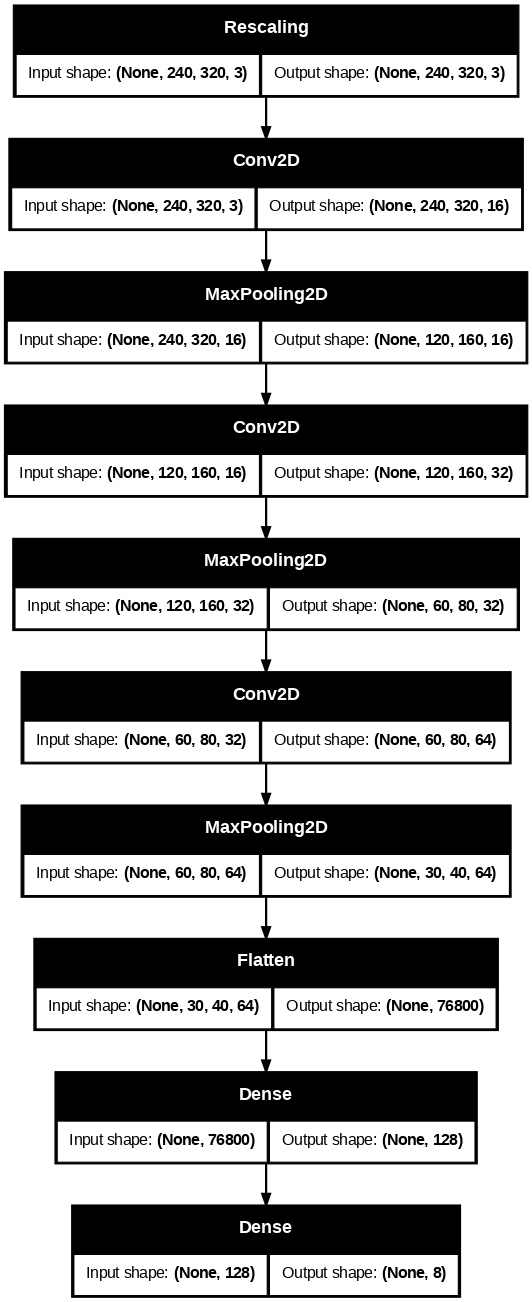

In [24]:
plot_model(cnn_model_1,
           to_file='model1.png',
           show_shapes=True,
           show_layer_names=False,
           rankdir='TB',
           dpi=80)

In [25]:
epochs=10
history_cnn_model_1 = cnn_model_1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 168s 3s/step - accuracy: 0.2666 - loss: 2.1127 - val_accuracy: 0.6625 - val_loss: 0.9145
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 166s 3s/step - accuracy: 0.7090 - loss: 0.7496 - val_accuracy: 0.8125 - val_loss: 0.5082
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 166s 3s/step - accuracy: 0.8823 - loss: 0.3641 - val_accuracy: 0.7975 - val_loss: 0.5683
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 171s 3s/step - accuracy: 0.9056 - loss: 0.2754 - val_accuracy: 0.8400 - val_loss: 0.4462
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 170s 3s/step - accuracy: 0.9343 - loss: 0.1807 - val_accuracy: 0.8525 - val_loss: 0.4837
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 165s 3s/step - accuracy: 0.9564 - loss: 0.1128 - val_accuracy: 0.8700 - val_loss: 0.4360
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 170s 3s/step - accuracy: 0.9831 - loss: 0.0648 - val_accuracy: 0.9000 - val_loss: 0.2903
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 203s 3s/step - accuracy: 0.9957 - loss: 0.0239 - val_accuracy: 0.9125 - v

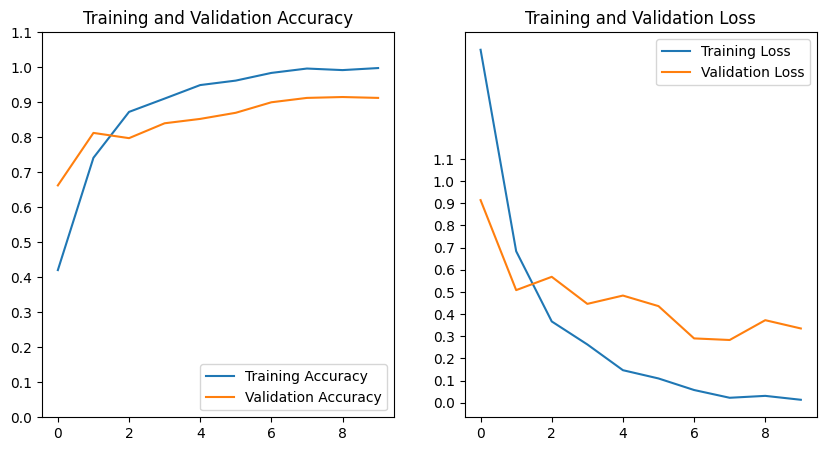

In [26]:
#Plotting Accuracy vs Validation Graphs
acc1 = history_cnn_model_1.history['accuracy']
val_acc1 = history_cnn_model_1.history['val_accuracy']

loss1 = history_cnn_model_1.history['loss']
val_loss1 = history_cnn_model_1.history['val_loss']

y_ticks = np.array([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1])
epochs_range = range(epochs)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc1, label='Training Accuracy')
plt.plot(epochs_range, val_acc1, label='Validation Accuracy')
plt.yticks(y_ticks)
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss1, label='Training Loss')
plt.plot(epochs_range, val_loss1, label='Validation Loss')
plt.yticks(y_ticks)
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [30]:
# Importing needed libraries
import matplotlib.pyplot as plt
import numpy as np
import h5py


from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from keras.callbacks import LearningRateScheduler


In [31]:
cnn_model_2 = Sequential()

# Adding first pair {8C5-P2}
cnn_model_2.add(Conv2D(8, kernel_size=5, padding='same', activation='relu', input_shape=(img_height, img_width, 3)))
cnn_model_2.add(MaxPool2D())

# Adding second pair {16C5-P2}
cnn_model_2.add(Conv2D(16, kernel_size=5, padding='same', activation='relu'))
cnn_model_2.add(MaxPool2D())

# Adding third pair {32C5-P2}
cnn_model_2.add(Conv2D(32, kernel_size=5, padding='same', activation='relu'))
cnn_model_2.add(MaxPool2D())

# Adding fourth pair {64C5-P2}
cnn_model_2.add(Conv2D(64, kernel_size=5, padding='same', activation='relu'))
cnn_model_2.add(MaxPool2D())

# Adding fully connected layers
cnn_model_2.add(Flatten())
cnn_model_2.add(Dense(128, activation='relu'))
cnn_model_2.add(Dense(8, activation='softmax'))

In [32]:
cnn_model_2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

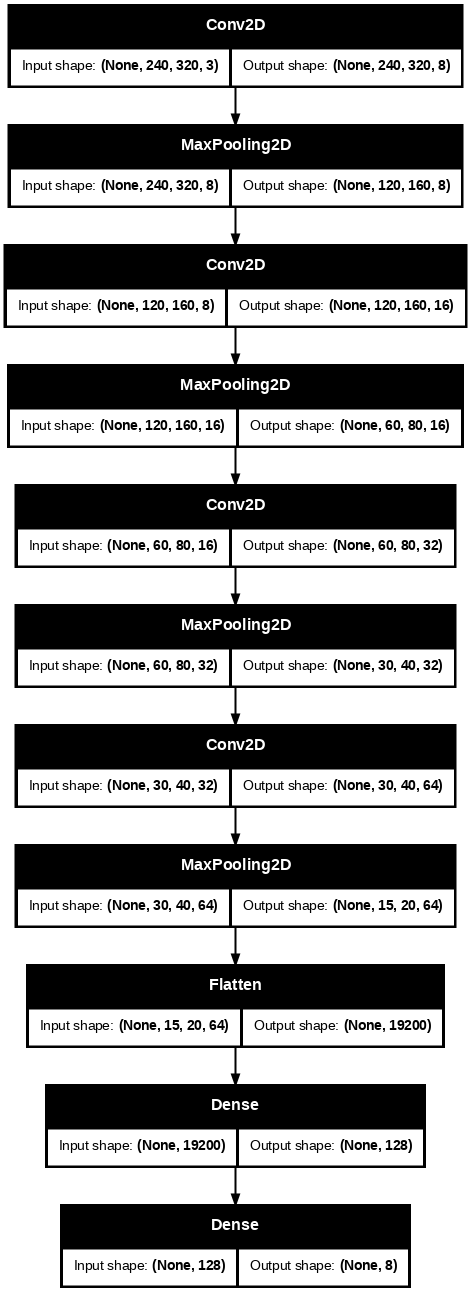

In [33]:
plot_model(cnn_model_2,
           to_file='model2.png',
           show_shapes=True,
           show_layer_names=False,
           rankdir='TB',
           dpi=72)

In [34]:
epochs = 10

# Defining schedule to update learning rate
learning_rate = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** (x + epochs), verbose=1)

In [35]:
epochs=10
history_cnn_model_2 = cnn_model_2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


57/57 ━━━━━━━━━━━━━━━━━━━━ 190s 3s/step - accuracy: 0.2091 - loss: 24.7204 - val_accuracy: 0.5425 - val_loss: 1.2922
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 182s 3s/step - accuracy: 0.6397 - loss: 1.0472 - val_accuracy: 0.7775 - val_loss: 0.6053
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 183s 3s/step - accuracy: 0.7718 - loss: 0.6769 - val_accuracy: 0.7975 - val_loss: 0.5330
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 183s 3s/step - accuracy: 0.8701 - loss: 0.3814 - val_accuracy: 0.8275 - val_loss: 0.5341
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 182s 3s/step - accuracy: 0.9181 - loss: 0.2372 - val_accuracy: 0.8775 - val_loss: 0.3528
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 187s 3s/step - accuracy: 0.9504 - loss: 0.1434 - val_accuracy: 0.8250 - val_loss: 0.5571
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 187s 3s/step - accuracy: 0.9358 - loss: 0.1889 - val_accuracy: 0.8325 - val_loss: 0.4526
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 182s 3s/step - accuracy: 0.9470 - loss: 0.1569 - val_accuracy: 0.8675 - val_loss: 0

range(0, 10)


Text(0.5, 1.0, 'Training and Validation Loss')

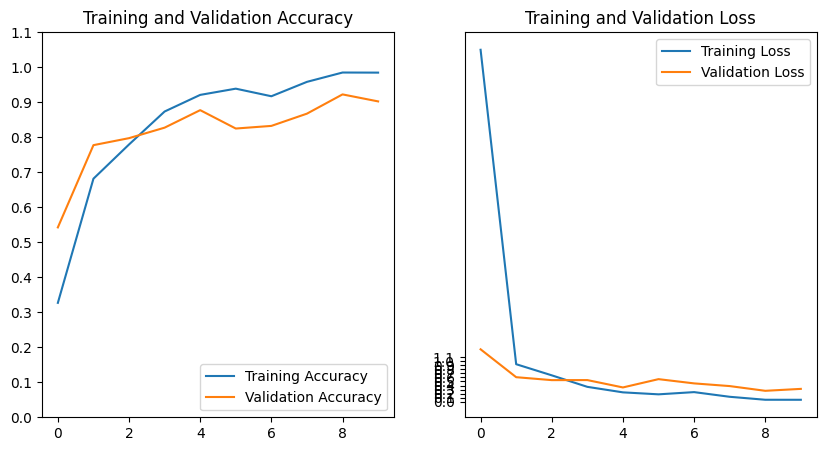

In [36]:
acc2 = history_cnn_model_2.history['accuracy']
val_acc2 = history_cnn_model_2.history['val_accuracy']

loss2 = history_cnn_model_2.history['loss']
val_loss2 = history_cnn_model_2.history['val_loss']

epochs_range = range(len(acc2))
print(epochs_range)

y_ticks = np.array([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1])
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc2, label='Training Accuracy')
plt.plot(epochs_range, val_acc2, label='Validation Accuracy')
plt.yticks(y_ticks)
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

epochs_range = range(epochs)
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss2, label='Training Loss')
plt.plot(epochs_range, val_loss2, label='Validation Loss')
plt.yticks(y_ticks)
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

# Random Forest Classification

In [37]:
import glob
from sklearn.model_selection import train_test_split
import os

data = []
labels = []

classes = {}
classes_dir = enumerate(os.listdir(data_dir))
for i, j in classes_dir:
    classes[j] = i
print(classes)


for i in class_names:
  pt = str(data_dir / i / '*.jpg')
  #print(pt)
  image_dir = glob.glob(pt)
  for j in image_dir:
    image=tf.keras.preprocessing.image.load_img(j, color_mode='rgb', 
    target_size= (240,320))
    image=np.array(image)
    data.append(image)
    labels.append(classes[i])
  #print(labels)
  

data = np.array(data)
labels = np.array(labels)
#print(data.shape)
#print(labels)

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2,random_state=42)
print (X_train.shape, X_test.shape, y_train.shape, y_test.shape)

{'Powdery Mildew': 0, 'Cutting Weevil': 1, 'Anthracnose': 2, 'Bacterial Canker': 3, 'Sooty Mould': 4, 'Gall Midge': 5, 'Healthy': 6, 'Die Back': 7}
(3200, 240, 320, 3) (800, 240, 320, 3) (3200,) (800,)


In [38]:
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

np.unique(y_train)
nsamples, nx, ny, nz = X_train.shape
X_train_modified = X_train.reshape((nsamples,nx*ny*nz))
nsamples, nx, ny, nz = X_test.shape
X_test_modified = X_test.reshape((nsamples,nx*ny*nz))

In [39]:
## Random Forest Classification
random_forest_model = RandomForestClassifier()
random_forest_model.fit(X_train_modified,y_train)
random_forest_model_prdiction = random_forest_model.predict(X_test_modified)
rf_acc = accuracy_score(random_forest_model_prdiction,y_test)
print("Report of Random Forest Classification - ")
print(classification_report(random_forest_model_prdiction,y_test))

Report of Random Forest Classification - 
              precision    recall  f1-score   support

           0       0.88      0.91      0.89        88
           1       1.00      0.96      0.98       117
           2       0.85      0.93      0.89       113
           3       0.92      0.88      0.90        90
           4       0.77      0.78      0.78        92
           5       0.83      0.85      0.84       101
           6       0.89      0.80      0.84       100
           7       0.93      0.95      0.94        99

    accuracy                           0.89       800
   macro avg       0.88      0.88      0.88       800
weighted avg       0.89      0.89      0.89       800



In [43]:
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, random_forest_model_prediction)
print("Confusion Matrix for Random Forest Classification:")
print(conf_matrix)


Confusion Matrix for Random Forest Classification:
[[ 81   0   1   1   3   2   3   0]
 [  0 112   0   0   0   0   0   0]
 [  0   2 110   1   3   1   3   3]
 [  0   0   3  79   1   1   0   2]
 [  2   0   3   2  77   5   4   0]
 [  2   0   1   6   8  82   5   0]
 [  1   0   0   0   6   2  81   0]
 [  0   2   3   1   0   0   0  95]]


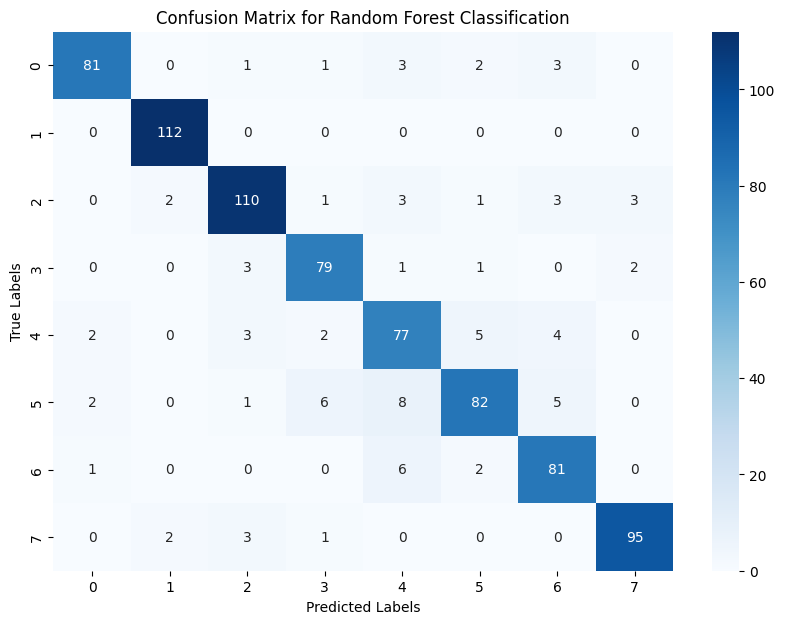

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, random_forest_model_prediction)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=True, yticklabels=True)

# Set labels and title
plt.title('Confusion Matrix for Random Forest Classification')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# Show the plot
plt.show()


# Decision Tree Classification

In [40]:
## Decision Tree Classification
decision_tree_classifier_model = DecisionTreeClassifier()
decision_tree_classifier_model.fit(X_train_modified,y_train)
decision_tree_prediction = decision_tree_classifier_model.predict(X_test_modified)
dt_acc = accuracy_score(decision_tree_prediction,y_test)
print("Report of Decision Tree Classification - ")
print(classification_report(decision_tree_prediction,y_test))
acc = decision_tree_classifier_model.score(X_test_modified,y_test)

Report of Decision Tree Classification - 
              precision    recall  f1-score   support

           0       0.68      0.65      0.67        95
           1       0.99      0.93      0.96       119
           2       0.66      0.73      0.69       111
           3       0.71      0.64      0.67        95
           4       0.47      0.55      0.51        80
           5       0.52      0.53      0.52       102
           6       0.60      0.60      0.60        90
           7       0.86      0.81      0.83       108

    accuracy                           0.69       800
   macro avg       0.69      0.68      0.68       800
weighted avg       0.70      0.69      0.70       800



In [45]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test, decision_tree_prediction)
print("Confusion Matrix of Decision Tree Classification:")
print(conf_matrix)


Confusion Matrix of Decision Tree Classification:
[[ 62   0   3   4   9   3   8   2]
 [  0 111   0   0   0   0   0   1]
 [  7   2  81   5   1  15   6   6]
 [  4   0   2  61   4   8   1   6]
 [  7   0  11   7  44   8  13   3]
 [  9   0   7  13  11  54   8   2]
 [  6   0   3   3  10  13  54   1]
 [  0   6   4   2   1   1   0  87]]


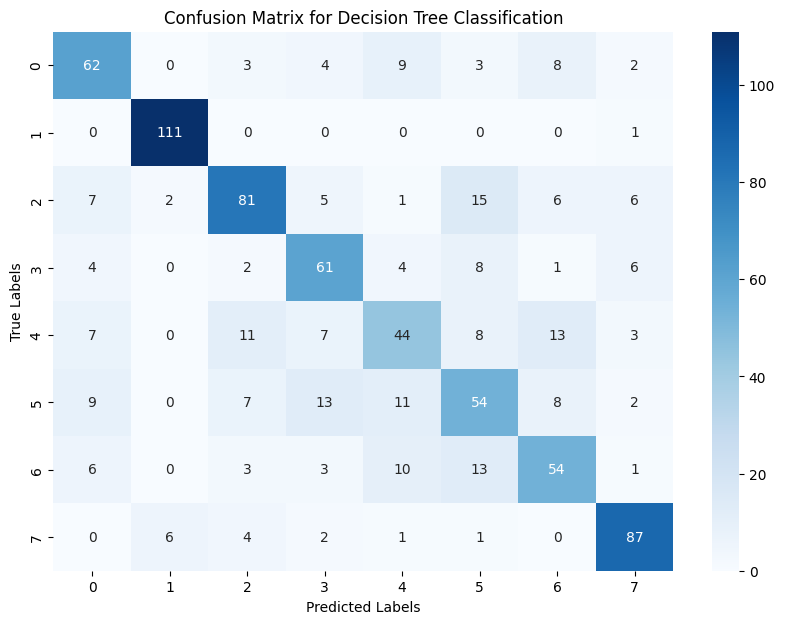

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, decision_tree_prediction)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=True, yticklabels=True)

# Set labels and title
plt.title('Confusion Matrix for Decision Tree Classification')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# Show the plot
plt.show()


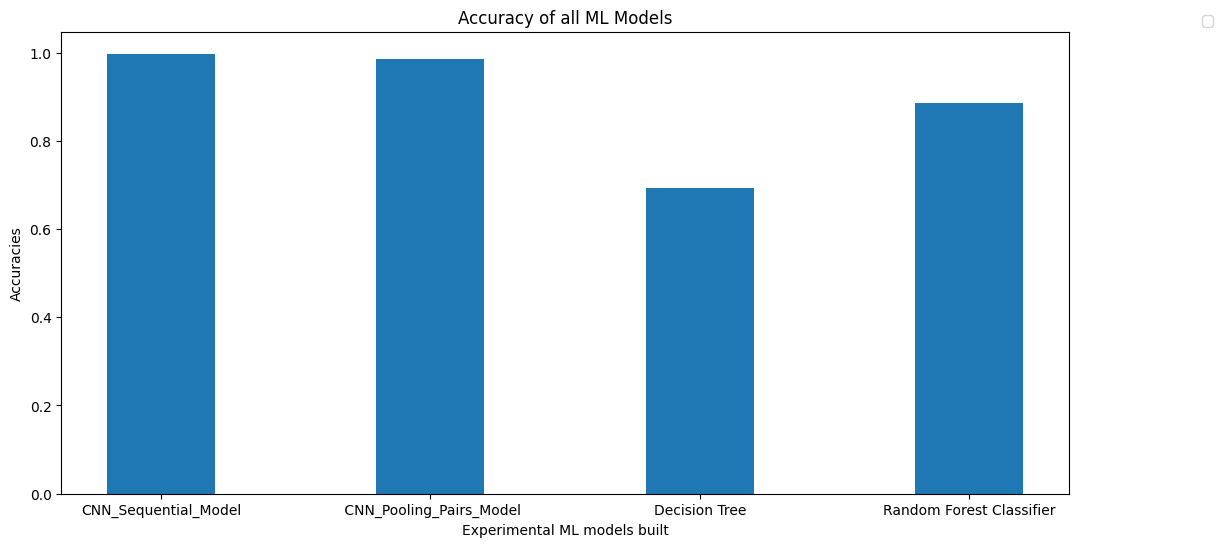

In [41]:
import pandas as pd
import matplotlib.pyplot as plt

models = ['CNN_Sequential_Model',' CNN_Pooling_Pairs_Model', 'Decision Tree', 'Random Forest Classifier']
val_accuracies = [acc1[len(acc1)-1], acc2[len(acc2)-1], dt_acc, rf_acc]
X_axis = np.arange(len(models))
fig = plt.figure(figsize = (13, 6))
 
# creating the bar plot
plt.bar(X_axis, val_accuracies, width = 0.4)
plt.xticks(X_axis, models)
plt.xlabel("Experimental ML models built")
plt.ylabel("Accuracies")
plt.title("Accuracy of all ML Models")
plt.legend(bbox_to_anchor=(1.15, 1.05))
plt.show()